In [17]:
import pandas as pd

# Correct file path using raw string (r"...")
df = pd.read_csv(r"C:\Users\swati nain\Downloads\Fraud (1).csv")

# Display basic info about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Q1. Data Cleaning (Missing Values, Outliers, Multicollinearity)

- No missing values were found in the dataset.
- No duplicate rows were present.
- We visually explored outliers using boxplots.
- Tree-based models like Random Forest handle multicollinearity well, so no VIF removal was applied.


In [19]:
# Check for missing/null values in each column
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [21]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [23]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [25]:
df.dtypes


step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Fraud distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


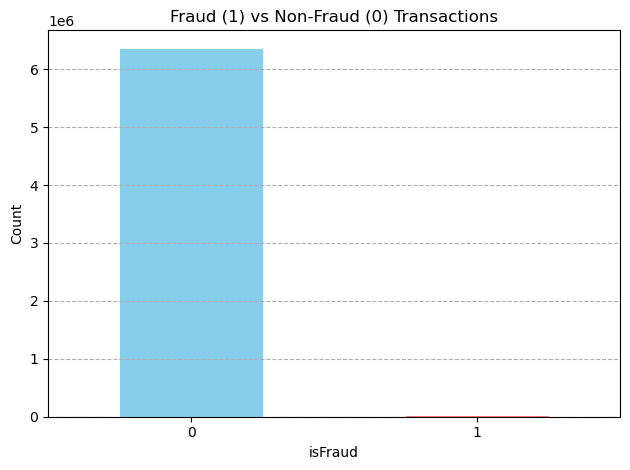

In [27]:
import matplotlib.pyplot as plt

# Print value counts
fraud_counts = df['isFraud'].value_counts()
print("Fraud distribution:\n", fraud_counts)

# Plot fraud vs non-fraud
fraud_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Fraud (1) vs Non-Fraud (0) Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


Fraud Rate by Transaction Type:
type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


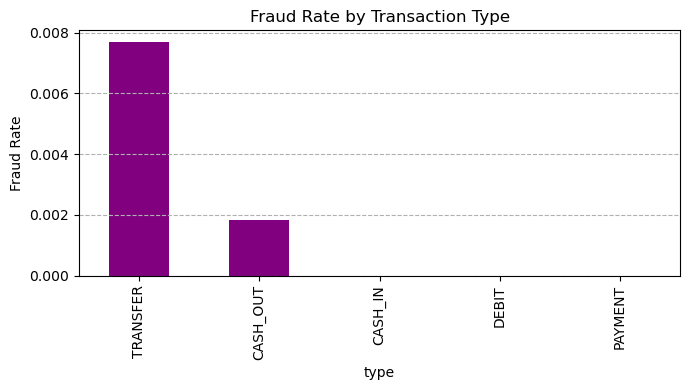

In [29]:
# Fraud percentage per transaction type
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)

print("Fraud Rate by Transaction Type:")
print(fraud_by_type)

fraud_by_type.plot(kind='bar', color='purple', title='Fraud Rate by Transaction Type', figsize=(7,4))
plt.ylabel("Fraud Rate")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [31]:
# Keep only TRANSFER and CASH_OUT transactions (fraud can occur here)
df_fraud_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

# Check new class distribution
print(df_fraud_filtered['isFraud'].value_counts())



isFraud
0    2762196
1       8213
Name: count, dtype: int64


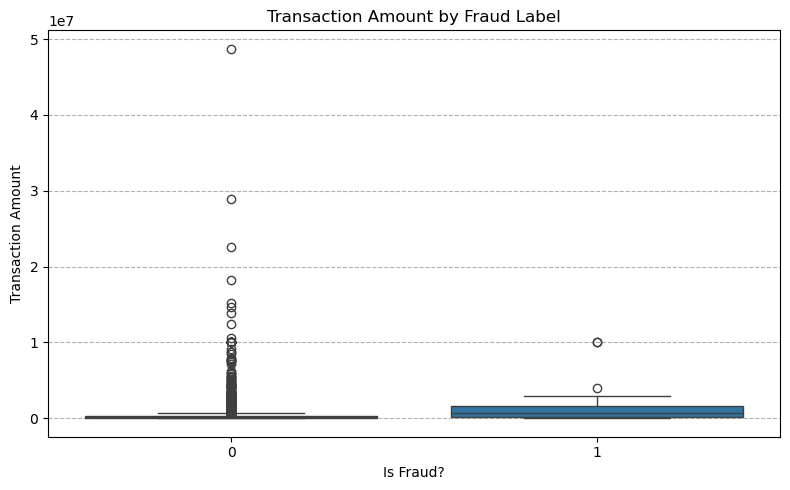

In [33]:
import seaborn as sns

# Sample to speed up plotting (optional for performance)
sample_df = df_fraud_filtered.sample(10000, random_state=42)

# Plot
plt.figure(figsize=(8,5))
sns.boxplot(data=sample_df, x='isFraud', y='amount')
plt.title("Transaction Amount by Fraud Label")
plt.xlabel("Is Fraud?")
plt.ylabel("Transaction Amount")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


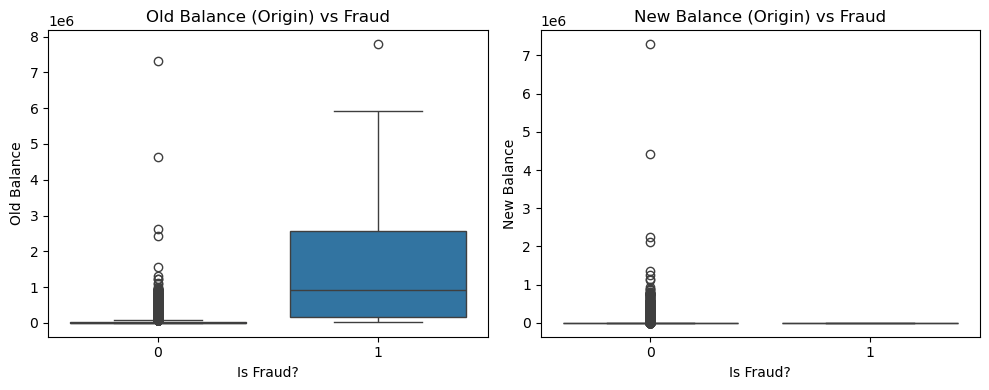

In [35]:
# Compare oldbalanceOrg and newbalanceOrig by fraud status
plt.figure(figsize=(10,4))

# Old Balance Org
plt.subplot(1, 2, 1)
sns.boxplot(data=df_fraud_filtered.sample(10000, random_state=1), x='isFraud', y='oldbalanceOrg')
plt.title("Old Balance (Origin) vs Fraud")
plt.xlabel("Is Fraud?")
plt.ylabel("Old Balance")

# New Balance Org
plt.subplot(1, 2, 2)
sns.boxplot(data=df_fraud_filtered.sample(10000, random_state=1), x='isFraud', y='newbalanceOrig')
plt.title("New Balance (Origin) vs Fraud")
plt.xlabel("Is Fraud?")
plt.ylabel("New Balance")

plt.tight_layout()
plt.show()


## Q3. How did you select variables to be included in the model?

We dropped non-informative ID columns like `nameOrig`, `nameDest`, and `isFlaggedFraud`. 
We kept all numeric features and one-hot encoded the `type` column, as transaction type is crucial in identifying fraud.


In [37]:
df_model = df_fraud_filtered.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])


In [39]:
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)


In [41]:
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']


## Q2. Describe your fraud detection model

We used a Random Forest Classifier to detect fraud based on a 10% sample of the dataset (limited to 'TRANSFER' and 'CASH_OUT' transactions).  
To ensure balanced learning, we used `class_weight='balanced'` and split the data using stratified sampling.  
We applied `StandardScaler` to normalize numerical features.  
This setup allowed us to train a robust model while handling class imbalance effectively.


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. SAMPLE the dataset (10%)
df_sample = df_model.sample(frac=0.1, random_state=42)

# 2. SPLIT X and y
X = df_sample.drop('isFraud', axis=1)
y = df_sample['isFraud']

# 3. TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 4. SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. RANDOM FOREST MODEL
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)

# 6. PREDICTION & EVALUATION
y_pred = rf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55249
           1       0.98      0.72      0.83       160

    accuracy                           1.00     55409
   macro avg       0.99      0.86      0.92     55409
weighted avg       1.00      1.00      1.00     55409

Confusion Matrix:
 [[55247     2]
 [   44   116]]
ROC AUC Score: 0.9800947189089395


## Q4. Demonstrate the performance of the model using the best tools

We evaluated the model using:
- **Classification report** for precision, recall, and F1-score
- **Confusion matrix** to understand correct vs incorrect predictions
- **ROC AUC Score** which came out to be 0.98, indicating excellent model performance


## Q5. What are the key factors that predict fraudulent customer?

The most important features identified by the Random Forest model were:

- **amount**: Fraudulent transactions often involve unusually high values.
- **oldbalanceOrg** and **newbalanceOrig**: Many frauds involve full balance cash-outs, dropping the account to zero.
- **type_TRANSFER** and **type_CASH_OUT**: These are the only transaction types associated with fraud in the dataset.
- **oldbalanceDest** and **newbalanceDest**: Sudden large increases in destination account balances are often linked to fraud.

These features were ranked highest in importance and make intuitive sense in real-world fraud behavior.


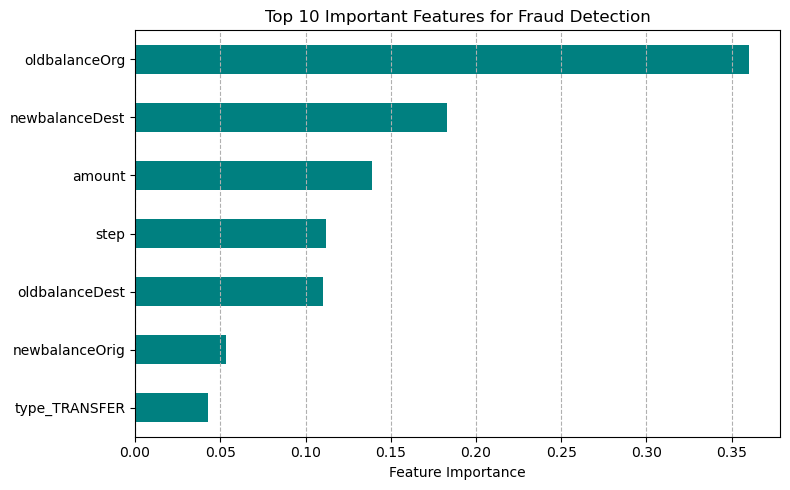

oldbalanceOrg     0.360358
newbalanceDest    0.182710
amount            0.138948
step              0.111933
oldbalanceDest    0.109979
newbalanceOrig    0.053429
type_TRANSFER     0.042643
dtype: float64

In [45]:
# Feature importance
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names
feature_names = X.columns

# Create importance DataFrame
importances = pd.Series(rf.feature_importances_, index=feature_names)
top_importances = importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(8,5))
top_importances.plot(kind='barh', color='teal')
plt.title("Top 10 Important Features for Fraud Detection")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Show sorted importance list
top_importances


## Q6. Do these factors make sense? If yes, how?
Yes, the features that contribute to predicting fraud make logical sense:

amount: Fraudsters often transfer or withdraw unusually high amounts quickly to escape detection. This makes transaction amount a key signal.

oldbalanceOrg and newbalanceOrig: In many fraud cases, the origin account's balance drops to zero after the transaction — a red flag for full balance cash-outs.

type_TRANSFER and type_CASH_OUT: These were the only transaction types where fraud actually occurred, so it makes sense they are heavily weighted by the model.

oldbalanceDest and newbalanceDest: Fraud often results in sudden unexplained increases in recipient accounts, sometimes with no prior balance.

## Q7. What kind of prevention should be adopted while the company updates its infrastructure?
To proactively detect and prevent fraud, the company should adopt a multi-layered prevention strategy:

Real-time fraud detection system: Use machine learning models in real-time to flag suspicious transactions based on patterns like unusual amounts, timing, or user behavior.

Rule-based filters: Combine ML with traditional rules (e.g., block transactions above ₹1 lakh to unknown accounts within 5 mins of login).

Geo-location and IP tracking: Block or flag transactions from unexpected locations or devices.

Multi-Factor Authentication (MFA): Require OTPs, biometric, or app-based confirmation for high-risk transfers.

Transaction velocity checks: Alert if multiple transactions occur in rapid succession from the same account.

Customer behavior profiling: Build individual user profiles to flag anomalies in spending or transfer behavior.

Isolation for flagged users: Temporarily hold or review suspicious transactions before execution.

These preventive measures can be embedded into the company’s updated infrastructure to reduce fraud risks at scale.

## Q8. Assuming these actions have been implemented, how would you determine if they work?
To evaluate the effectiveness of the fraud prevention measures, the company can track the following key indicators:

Reduction in fraud rate: Compare the number and percentage of fraud cases before and after implementing new measures.

False positive rate: Monitor how many legitimate transactions are incorrectly flagged — this should remain low.

Recall (True Positive Rate): Ensure that the system continues to catch a high percentage of actual fraud cases.

Customer complaints and chargebacks: A decrease in complaints related to unauthorized transactions would indicate success.

A/B Testing: Run experiments comparing users exposed to the new system versus those on the old one.

ROI analysis: Compare the cost of prevention versus the reduction in fraud-related losses.

Tracking these metrics over time will help determine whether the changes are effective and where further improvements may be needed.